# Combo Builder

## Building Structure

In [291]:
%%capture
%pip install numpy
%pip install scipy

In [292]:
import random
import pickle
import re
import pandas as pd

In [293]:
def pretty(d, indent=0):
   for key, value in d.items():
      print('\t' * indent + str(key))
      if isinstance(value, dict):
         pretty(value, indent+1)
      else:
         print('\t' * (indent+1) + str(value))



## Defining Development Sets / Layers

### Split by Occasion / Category (NEEDS DISTINCTION)

Here we will need a way to parse incoming Dev_Set Definitions as Dicts

In [294]:
with open('../DEL/Mappings/dev_set_map.pkl', 'rb') as f:
    dev_sets = pickle.load(f)
xl = pd.ExcelFile('../Data/Reseller.xlsx')
df = xl.parse('Sheet1')
products = df["Product"].tolist()

### Splitting by Brand

In [295]:
def split_by_brand(data, products, brands=None):
    if (not brands):
        brands = ['COKE', 'DR PEP', 'DNKN', 'BANG', 'FLIFE', 'SMTWTR',
        'SPRITE', 'FANTA', 'MM', 'SEAG', 'PA', 'GLD PK',
        'VW', 'FRESCA', 'MON', 'COR PWR', 'DAS', 'BA ', 'AHA', 'FUZ',
        'BARQS', 'RGN', 'TOPCO', 'PCE TEA', 'NOS', 'UNKNOWN']
        
    
    for ds in data.keys():
        brand_sets = {}
        brand_sets['UNKNOWN'] = []
        print(products)
        for product in products:
            matched = False
            for brand in brands:
                if brand in product:
                    brand_sets[brand] = []
                    brand_sets[brand].append(product)
                    matched = True
                    break
            if not matched:
                brand_sets['UNKNOWN'].append(product)
        data[ds] = brand_sets

In [ ]:
split_by_brand(dev_sets, products)
split_by_package_type(dev_sets, products)
process_dict(dev_sets, products)
pretty(dev_sets)

### Splitting by Package Type

In [297]:
def split_by_package_type(data, products):
    for dev_set, brands in data.items():
        data[dev_set] = {}
        for brand, products in brands.items():
            data[dev_set][brand] = {}
            for product in products:
                # Split the string into words
                details = product.split()
                package_type = " ".join(details[:2])
                if package_type not in data[dev_set][brand]:
                    data[dev_set][brand][package_type] = []
                data[dev_set][brand][package_type].append(product)



### Splitting by Pack Size

In [298]:
import re

def process_dict(data, products):
    for dev_set, brands in data.items():
        for brand, product_types in brands.items():
            for product_type, products in product_types.items():
                new_dict = {}
                for product in products:
                    info_bits = product.split()
                    if len(info_bits) >= 3:
                        number = ''.join(re.findall(r'\d+', info_bits[2][:2]))
                        if number:
                            if number not in new_dict:
                                new_dict[number] = []
                            new_dict[number].append(product)
                        else:
                            if 'UNKNOWN' not in new_dict:
                                new_dict['UNKNOWN'] = []
                            new_dict['UNKNOWN'].append(product)
                data[dev_set][brand][product_type] = new_dict
    return data


### All Together Now

In [299]:
def decompose_dictionary(data, products):
    brands = ['COKE', 'DR PEP', 'DNKN', 'BANG', 'FLIFE', 'SMTWTR',
              'SPRITE', 'FANTA', 'MM', 'SEAG', 'PA', 'GLD PK',
              'VW', 'FRESCA', 'MON', 'COR PWR', 'DAS', 'BA ', 'AHA', 'FUZ',
              'BARQS', 'RGN', 'TOPCO', 'PCE TEA', 'NOS', 'UNKNOWN']

    for ds in data.keys():
        brand_sets = {key: [] for key in brands}
        for product in data[ds]:
            matched = False
            for brand in brands:
                if brand in product:
                    brand_sets[brand].append(product)
                    matched = True
                    break
            if not matched:
                brand_sets['UNKNOWN'].append(product)

        for brand, products in brand_sets.items():
            package_types = {}
            for product in products:
                details = product.split()
                package_type = " ".join(details[:2])
                if package_type not in package_types:
                    package_types[package_type] = []
                package_types[package_type].append(product)

            for product_type, products in package_types.items():
                package_sizes = {}
                for product in products:
                    info_bits = product.split()
                    if len(info_bits) >= 3:
                        number = re.match(r'\d+[A-Za-z]?', info_bits[2])
                        if number:
                            number = number.group()
                            if number not in package_sizes:
                                package_sizes[number] = []
                            package_sizes[number].append(product)
                        else:
                            if 'UNKNOWN' not in package_sizes:
                                package_sizes['UNKNOWN'] = []
                            package_sizes['UNKNOWN'].append(product)
                package_types[product_type] = package_sizes

            brand_sets[brand] = package_types

        data[ds] = brand_sets

    return data


In [300]:
with open('../DEL/Mappings/dev_set_map.pkl', 'rb') as f:
    dev_sets = pickle.load(f)

decompose_dictionary(dev_sets, products)

pretty(dev_sets)

single-serve
	COKE
		12Z CN
			12F
				['12Z CN 12FP COKE', '12Z CN 12FP DT COKE', '12Z CN 12FP COKE ZS', '12Z CN 12FP COKE CHRY', '12Z CN 12FP COKE VAN', '12Z CN 12FP COKE CHRY VAN', '12Z CN 12FP COKE CHRY ZRO', '12Z CN 12FP CF DT COKE', '12Z CN 12FP CF COKE', '12Z CN 12FP COKE ZS SPCE', '12Z CN 12FP COKE SPCE', '12Z CN 12FP COKE CHRY VAN ZS']
			24P
				['12Z CN 24P COKE ZS', '12Z CN 24P COKE', '12Z CN 24P DT COKE']
			6P
				['12Z CN 6P HC COKE']
			UNKNOWN
				['12Z CN SLK 24LS TS COKE', '12Z CN SLK 24LS TS DT COKE', '12Z CN SLK 24LS TS COKE ZS', '12Z CN SLK 24LS TS COKE SPCE']
		20Z PT
			24L
				['20Z PT 24LS COKE', '20Z PT 24LS DT COKE', '20Z PT 24LS COKE ZS', '20Z PT 24LS COKE VAN', '20Z PT 24LS COKE CHRY', '20Z PT 24LS COKE CHRY VAN', '20Z PT 24LS COKE CHRY ZRO', '20Z PT 24LS COKE SPCE', '20Z PT 24LS CF DT COKE', '20Z PT 24LS TS DT COKE', '20Z PT 24LS COKE MOVE', '20Z PT 24LS COKE ZS MOVE', '20Z PT 24LS TS COKE ZS', '20Z PT 24LS COKE ZS SPCE']
			24P
				['20Z PT 24P DT COKE_C

In [301]:
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 10)
print(dev_sets)

{'single-serve': {'COKE': {'12Z CN': {'12F': ['12Z CN 12FP COKE', '12Z CN 12FP DT COKE', '12Z CN 12FP COKE ZS', '12Z CN 12FP COKE CHRY', '12Z CN 12FP COKE VAN', '12Z CN 12FP COKE CHRY VAN', '12Z CN 12FP COKE CHRY ZRO', '12Z CN 12FP CF DT COKE', '12Z CN 12FP CF COKE', '12Z CN 12FP COKE ZS SPCE', '12Z CN 12FP COKE SPCE', '12Z CN 12FP COKE CHRY VAN ZS'], '24P': ['12Z CN 24P COKE ZS', '12Z CN 24P COKE', '12Z CN 24P DT COKE'], '6P': ['12Z CN 6P HC COKE'], 'UNKNOWN': ['12Z CN SLK 24LS TS COKE', '12Z CN SLK 24LS TS DT COKE', '12Z CN SLK 24LS TS COKE ZS', '12Z CN SLK 24LS TS COKE SPCE']}, '20Z PT': {'24L': ['20Z PT 24LS COKE', '20Z PT 24LS DT COKE', '20Z PT 24LS COKE ZS', '20Z PT 24LS COKE VAN', '20Z PT 24LS COKE CHRY', '20Z PT 24LS COKE CHRY VAN', '20Z PT 24LS COKE CHRY ZRO', '20Z PT 24LS COKE SPCE', '20Z PT 24LS CF DT COKE', '20Z PT 24LS TS DT COKE', '20Z PT 24LS COKE MOVE', '20Z PT 24LS COKE ZS MOVE', '20Z PT 24LS TS COKE ZS', '20Z PT 24LS COKE ZS SPCE'], '24P': ['20Z PT 24P DT COKE_CB']}, 

# Building Combos

Assume working with Dictionary with the following structure:
<pre>
{ Development Set :  
    { Brand :  
        { Package Type :  
            { Pack Size :  
                 [ SKUs ordered by descending SOM ]

            }
        }
    }
}
</pre>

Or Pandas Dataframe as below
<pre>
___________________________________________________
| Product Code* | Product* | BrandFlavor | SOM | Volume |
|_______________|__________|_____________|________|
</pre>
This table can have more columns, such as popularity, proportion of reseller volume, etc. Which will be used to cluster.

### Building Development Set Table from Data

In [302]:
import pandas as pd
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 20)

In [303]:
xl = pd.ExcelFile('../Data/Reseller.xlsx')
df = xl.parse('Sheet1')

### Sort by Volume

In [304]:
df = df.iloc[:, 3:7]

# Assign total volumes to SKU and sort by Volume
df_by_volume = df.groupby(df.columns[0]).agg({df.columns[1]: 'first', df.columns[2]: 'first', df.columns[3]: 'sum'})

df_by_volume = df_by_volume[df_by_volume['Volume'] > 0]

# Calculate total volume
total_volume = df_by_volume['Volume'].sum()

# Calculate market share for each product and add it as a new column
df_by_volume['SOM'] = (df_by_volume['Volume'] / total_volume)
df_by_volume = df_by_volume.sort_values(by=df.columns[3], ascending=False)

In [305]:
print(df_by_volume)

                               Product          BrandFlavor    Volume           SOM
Product host code                                                                  
115583.0              12Z CN 12FP COKE            COCA-COLA  151066.0  1.349324e-01
153077.0             2L PT 8LS TS COKE            COCA-COLA   78590.0  7.019672e-02
115584.0           12Z CN 12FP DT COKE            DIET COKE   60575.0  5.410569e-02
119826.0              20Z PT 24LS COKE            COCA-COLA   55295.0  4.938959e-02
115586.0            12Z CN 12FP SPRITE               SPRITE   52861.0  4.721553e-02
...                                ...                  ...       ...           ...
151793.0           7.5Z CN SLK 10FP...         DR PEPPER-CS       1.0  8.932017e-07
412187.0           12Z CN SLK 12LS ...  REIGN STORM CLEA...       1.0  8.932017e-07
412158.0           16.9Z PT 12PX1 S...  GOLD PEAK SWEETE...       1.0  8.932017e-07
158570.0           16.9Z PT 6P CL C...  COCA-COLA ZERO S...       1.0  8.932

### Sort by SOM

In [306]:
df_grouped = df.groupby('Product host code').agg({'Product': 'first', 'BrandFlavor': 'first', 'Volume': 'sum'})

# Filter out groups with a negative sum
df_grouped = df_grouped[df_grouped['Volume'] > 0]

# Calculate total volume
total_volume = df_grouped['Volume'].sum()

# Calculate market share for each product and add it as a new column
df_grouped['SOM'] = (df_grouped['Volume'] / total_volume)

# Sort by market share
df_grouped = df_grouped.sort_values(by='SOM', ascending=False)

# Print the resulting DataFrame
print(df_grouped)

                               Product          BrandFlavor    Volume           SOM
Product host code                                                                  
115583.0              12Z CN 12FP COKE            COCA-COLA  151066.0  1.349324e-01
153077.0             2L PT 8LS TS COKE            COCA-COLA   78590.0  7.019672e-02
115584.0           12Z CN 12FP DT COKE            DIET COKE   60575.0  5.410569e-02
119826.0              20Z PT 24LS COKE            COCA-COLA   55295.0  4.938959e-02
115586.0            12Z CN 12FP SPRITE               SPRITE   52861.0  4.721553e-02
...                                ...                  ...       ...           ...
151793.0           7.5Z CN SLK 10FP...         DR PEPPER-CS       1.0  8.932017e-07
412187.0           12Z CN SLK 12LS ...  REIGN STORM CLEA...       1.0  8.932017e-07
412158.0           16.9Z PT 12PX1 S...  GOLD PEAK SWEETE...       1.0  8.932017e-07
158570.0           16.9Z PT 6P CL C...  COCA-COLA ZERO S...       1.0  8.932

### Splitting by Segment

In [307]:
with open('../DEL/Mappings/dev_set_map.pkl', 'rb') as f:
    customer_segments = pickle.load(f)

In [308]:
import pandas as pd

dev_set_size = 15

# Create a new dictionary to store the dataframes for each customer segment
df_dict = {}

# Iterate over each customer segment in the dictionary
for segment, products in customer_segments.items():
    # Filter the original dataframe to only include rows where the product description is in the list of relevant products for that segment
    df_segment = df_grouped[df_grouped['Product'].isin(products)]
    
    # Sort the filtered dataframe by volume
    df_segment = df_segment.sort_values(by='Volume', ascending=False)
    
    # Trim the dataframe to 25 or less entries
    df_segment = df_segment.head(dev_set_size)  

    # Add relative SOM
    total_m = df_segment['SOM'].sum()
    df_segment['RSOM'] = df_segment['SOM'] / total_m

    # Store the sorted dataframe in the new dictionary under the key that is the relevant customer segment
    df_dict[segment] = df_segment

In [309]:
# Print the dataframes for each customer segment
pretty(df_dict)
"""for segment, df_segment in df_dict.items():
    print(f"\nCustomer Segment: {segment}")
    print(df_segment)
"""

single-serve
	                               Product          BrandFlavor    Volume       SOM      RSOM
Product host code                                                                        
115583.0              12Z CN 12FP COKE            COCA-COLA  151066.0  0.134932  0.291340
115584.0           12Z CN 12FP DT COKE            DIET COKE   60575.0  0.054106  0.116823
119826.0              20Z PT 24LS COKE            COCA-COLA   55295.0  0.049390  0.106640
115586.0            12Z CN 12FP SPRITE               SPRITE   52861.0  0.047216  0.101946
117559.0            ND12Z CN 12FP COKE            COCA-COLA   27188.0  0.024284  0.052434
156090.0           20Z PT 12LS VW P...  GLACEAU VWTR PWR...   22851.0  0.020411  0.044070
103029.0           20Z PT 24LS TS S...               SPRITE   19693.0  0.017590  0.037979
119827.0           20Z PT 24LS DT COKE            DIET COKE   19329.0  0.017265  0.037277
156091.0            20Z PT 12LS VW NRG  GLACEAU VWTR ENE...   18449.0  0.016479  0.035

'for segment, df_segment in df_dict.items():\n    print(f"\nCustomer Segment: {segment}")\n    print(df_segment)\n'

## Bundling

In [310]:
from itertools import combinations
import random

In [311]:
def generate_random_assortment_bundles(dev_sets, max_bundle_size=2):
    all_combos_list = []
    labels = []
    for segment, df_segment in dev_sets.items():
        labels.append(segment)
        product_labels = df_segment['Product'].tolist()
        all_combos_list.append([(comb, random.randint(0, 10)) for r in range(1, 3) for comb in combinations(product_labels[:6], r)])
    return all_combos_list

def generate_bundles_single_devset(dev_sets, dev_set_name):
    SKUs = dev_sets[dev_set_name].index.tolist()
    #combo_list = ([[comb, 0] for r in range(1, 3) for comb in combinations(SKUs[:6], r)])
    combo_list = [[comb] for comb in SKUs[:6]]
    return pd.DataFrame(combo_list, columns=["Product"])

In [312]:
selected_dev_set = "energy"
all_combos = generate_bundles_single_devset(df_dict, selected_dev_set)
print(all_combos)

    Product
0  156091.0
1  133129.0
2  145105.0
3  133131.0
4  133145.0
5  153389.0


In [313]:
# Discount Eligibility
print(df_dict[selected_dev_set]['RSOM'] < 0.10)

Product host code
156091.0    False
133129.0    False
145105.0     True
133131.0     True
133145.0     True
153389.0     True
410384.0     True
412550.0     True
412549.0     True
412547.0     True
412556.0     True
150706.0     True
412548.0     True
412555.0     True
412558.0     True
Name: RSOM, dtype: bool


In [314]:
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 0)

desired_total_discount = 0.03

In [315]:
merged_df = all_combos.merge(df_dict['energy'][['Volume', 'SOM', 'RSOM']], left_on='Product', right_index=True, how='left')
print(merged_df)

    Product   Volume       SOM      RSOM
0  156091.0  18449.0  0.016479  0.399269
1  133129.0  16145.0  0.014421  0.349406
2  145105.0  3748.0   0.003348  0.081113
3  133131.0  1596.0   0.001426  0.034540
4  133145.0  716.0    0.000640  0.015495
5  153389.0  692.0    0.000618  0.014976


In [316]:
promoed_products = df_dict['energy'].loc[all_combos['Product']]
print(promoed_products)

                                              Product                         BrandFlavor   Volume       SOM      RSOM
Product host code                                                                                                     
156091.0           20Z PT 12LS VW NRG                  GLACEAU VWTR ENERGY-KO              18449.0  0.016479  0.399269
133129.0           16Z CN 24LS TS MON NRG              MONSTER ENERGY-KO                   16145.0  0.014421  0.349406
145105.0           16Z CN 24LS TS MON NRG ULT ZS       MONSTER ENERGY ULTRA ZERO SUGAR-KO  3748.0   0.003348  0.081113
133131.0           16Z CN 24LS TS MON NRG LO CARB      MONSTER LOCARB ENERGY-KO            1596.0   0.001426  0.034540
133145.0           24Z CN 12LS TS MON NRG MEGA         MEGA MONSTER ENERGY-KO              716.0    0.000640  0.015495
153389.0           16Z CN 24LS TS MON NRG JCE MNG LOC  MONSTER ENERGY JUICE MANGO LOCO-KO  692.0    0.000618  0.014976


In [317]:
total_volume = merged_df['Volume'].sum()

discount_by_volume_function = merged_df['Volume'] ** 0.9
net_discount = 0.01

merged_df['discount'] = (total_volume / discount_by_volume_function) * net_discount

# Normalize the discounts so that the weighted average is 3%
merged_df['discount'] = merged_df['discount'] / (merged_df['discount'] * merged_df['Volume']).sum() * total_volume * 0.03

# Print the dataframe
print(merged_df)

    Product   Volume       SOM      RSOM  discount
0  156091.0  18449.0  0.016479  0.399269  0.013274
1  133129.0  16145.0  0.014421  0.349406  0.014967
2  145105.0  3748.0   0.003348  0.081113  0.055713
3  133131.0  1596.0   0.001426  0.034540  0.120128
4  133145.0  716.0    0.000640  0.015495  0.247145
5  153389.0  692.0    0.000618  0.014976  0.254846


In [318]:
print((merged_df['Volume'] - merged_df['discount'] * merged_df['Volume']).sum() / merged_df['Volume'].sum())

0.9700000000000001


#### Type 1 Bundle: Single Product Discount

In [319]:
def generate_type_1_bundle(dev_sets, dev_set_name):
    SKUs = dev_sets[dev_set_name].index.tolist()
    #combo_list = ([[comb, 0] for r in range(1, 3) for comb in combinations(SKUs[:6], r)])
    combo_list = [[comb] for comb in SKUs]
    return pd.DataFrame(combo_list, columns=["Product", "Discount"])

In [320]:
import pandas as pd

# Assuming the first dataframe is df1 and the second dataframe is df2

# Convert the tuples in df1 to lists
#all_combos['Product'] = all_combos['Product'].apply(lambda x: list(x))

# Initialize an empty list to store the matched data
matched_data = []

# Iterate over each row in df1
for index, row in all_combos.iterrows():
    # Initialize an empty list to store the SOM values for the current product IDs
    som_values = []
    # Iterate over each product ID in the current row
    for product_id in row['Product']:
        # If the product ID is in df2, append its SOM value to som_values
        if product_id in promoed_products.index:
            som_values.append(promoed_products.loc[product_id, 'RSOM'])
    # Append the SOM values to matched_data as a tuple
    matched_data.append(som_values)

# Add the matched data to df1 as a new column
all_combos['MatchedSOM'] = matched_data

# Sort df1 by 'MatchedSOM'
all_combos['SOM Sum'] = all_combos['MatchedSOM'].apply(sum)
all_combos['SOM Sum'] /= all_combos['SOM Sum'].sum()
all_combos = all_combos.sort_values(by='SOM Sum', ascending=False)

# Print the sorted dataframe
print(all_combos)



TypeError: 'numpy.float64' object is not iterable

In [326]:
df_dict = {}
dev_set_names = []

def get_list_by_volume(products_df):
    df_by_volume = products_df.groupby(products_df.columns[0]).agg({products_df.columns[1]: 'first', products_df.columns[2]: 'first', products_df.columns[3]: 'sum'})
    df_by_volume = df_by_volume[df_by_volume['Volume'] > 0]
    total_volume = df_by_volume['Volume'].sum()
    df_by_volume['SOM'] = (df_by_volume['Volume'] / total_volume) * 100
    df_by_volume = df_by_volume.sort_values(by=df_by_volume.columns[3], ascending=False)
    return df_by_volume

def split_by_dev_set(df_by_volume, dev_set_mappings, dev_set_size = 5):
    dev_set_size = 5
    for segment, products in dev_set_mappings.items():
        dev_set_names.append(segment)
        df_segment = df_by_volume[df_by_volume['Product'].isin(products)]
        df_segment = df_segment.sort_values(by='Volume', ascending=False)
        df_segment = df_segment.head(dev_set_size)
        total_m = df_segment['SOM'].sum()
        df_segment['RSOM'] = df_segment['SOM'] / total_m * 100
        df_dict[segment] = df_segment

with open('../DEL/Mappings/dev_set_map.pkl', 'rb') as f:
    customer_segments = pickle.load(f)

xl = pd.ExcelFile('../Data/Reseller.xlsx')
products_df = xl.parse('Sheet1').iloc[:, 3:7]

product_list_by_volume = get_list_by_volume(products_df)
split_by_dev_set(product_list_by_volume, customer_segments, dev_set_size=15)


def generate_bundles_type1(dev_set_name, net_discount):
    SKUs = df_dict[dev_set_name].index.tolist()
    combo_list = [[comb] for comb in SKUs]
    all_combos = pd.DataFrame(combo_list, columns=["Product"])
    promoed_products = df_dict['energy'].loc[all_combos['Product']]
    total_volume = promoed_products['Volume'].sum()
    discount_by_volume_function = promoed_products['Volume'] ** 0.85
    promoed_products['discount'] = (total_volume / discount_by_volume_function) * net_discount
    promoed_products['discount'] = promoed_products['discount'] / (promoed_products['discount'] * promoed_products['Volume']).sum() * total_volume * net_discount
    return promoed_products#.to_json()


In [327]:
print(generate_bundles_type1("energy", 3))

                                          Product                         BrandFlavor   Volume       SOM       RSOM   discount
Product host code                                                                                                             
156091.0           20Z PT 12LS VW NRG              GLACEAU VWTR ENERGY-KO              18449.0  1.647868  45.380528  1.622466 
133129.0           16Z CN 24LS TS MON NRG          MONSTER ENERGY-KO                   16145.0  1.442074  39.713189  1.817273 
145105.0           16Z CN 24LS TS MON NRG ULT ZS   MONSTER ENERGY ULTRA ZERO SUGAR-KO  3748.0   0.334772  9.219265   6.288150 
133131.0           16Z CN 24LS TS MON NRG LO CARB  MONSTER LOCARB ENERGY-KO            1596.0   0.142555  3.925813   12.991958
133145.0           24Z CN 12LS TS MON NRG MEGA     MEGA MONSTER ENERGY-KO              716.0    0.063953  1.761204   25.678904


In [325]:
def generate_bundles_type2(dev_set_name, net_discount):
    SKUs = df_dict[dev_set_name]['Product'].tolist()
    combo_list = ([{'IDs': comb, 'Quantity': 0, 'Discount': 0} for r in range(2, 3) for comb in combinations(SKUs[:6], r)])
    return combo_list

print(generate_bundles_type2("single-serve", 3))

[{'IDs': ('12Z CN 12FP COKE', '12Z CN 12FP DT COKE'), 'Quantity': 0, 'Discount': 0}, {'IDs': ('12Z CN 12FP COKE', '20Z PT 24LS COKE'), 'Quantity': 0, 'Discount': 0}, {'IDs': ('12Z CN 12FP COKE', '12Z CN 12FP SPRITE'), 'Quantity': 0, 'Discount': 0}, {'IDs': ('12Z CN 12FP COKE', 'ND12Z CN 12FP COKE'), 'Quantity': 0, 'Discount': 0}, {'IDs': ('12Z CN 12FP DT COKE', '20Z PT 24LS COKE'), 'Quantity': 0, 'Discount': 0}, {'IDs': ('12Z CN 12FP DT COKE', '12Z CN 12FP SPRITE'), 'Quantity': 0, 'Discount': 0}, {'IDs': ('12Z CN 12FP DT COKE', 'ND12Z CN 12FP COKE'), 'Quantity': 0, 'Discount': 0}, {'IDs': ('20Z PT 24LS COKE', '12Z CN 12FP SPRITE'), 'Quantity': 0, 'Discount': 0}, {'IDs': ('20Z PT 24LS COKE', 'ND12Z CN 12FP COKE'), 'Quantity': 0, 'Discount': 0}, {'IDs': ('12Z CN 12FP SPRITE', 'ND12Z CN 12FP COKE'), 'Quantity': 0, 'Discount': 0}]


# Defining Dev Sets from BEACH

In [40]:
print(df_by_volume)

                               Product          BrandFlavor    Volume           SOM
Product host code                                                                  
115583.0              12Z CN 12FP COKE            COCA-COLA  151066.0  1.349324e-01
153077.0             2L PT 8LS TS COKE            COCA-COLA   78590.0  7.019672e-02
115584.0           12Z CN 12FP DT COKE            DIET COKE   60575.0  5.410569e-02
119826.0              20Z PT 24LS COKE            COCA-COLA   55295.0  4.938959e-02
115586.0            12Z CN 12FP SPRITE               SPRITE   52861.0  4.721553e-02
...                                ...                  ...       ...           ...
151793.0           7.5Z CN SLK 10FP...         DR PEPPER-CS       1.0  8.932017e-07
412187.0           12Z CN SLK 12LS ...  REIGN STORM CLEA...       1.0  8.932017e-07
412158.0           16.9Z PT 12PX1 S...  GOLD PEAK SWEETE...       1.0  8.932017e-07
158570.0           16.9Z PT 6P CL C...  COCA-COLA ZERO S...       1.0  8.932

In [42]:
print(sorted(df_by_volume["BrandFlavor"].unique()))

['#   Not assigned', 'AHA BLUEBERRY POMEGRANATE-KO', 'AHA LIME WATERMELON-KO', 'BANG ENERGY BLACK CHERRY VANILLA-KO', 'BANG ENERGY BLUE RAZZ-KO', 'BANG ENERGY COTTON CANDY-KO', 'BANG ENERGY DELISH STRAWBERRY KISS-KO', 'BANG ENERGY PEACH MANGO-KO', 'BANG ENERGY PURPLE HAZE-KO', 'BANG ENERGY RADICAL SKADATTLE-KO', 'BANG ENERGY RAINBOW UNICORN-KO', 'BANG ENERGY SOUR HEADS-KO', 'BANG ENERGY STAR BLAST-KO', 'BANG ENERGY WYLDIN WATERMELON-KO', 'BARQS ROOT BEER', 'BODYARMOR FLASH IV ORANGE-KO', 'BODYARMOR LYTE BLUEBERRY POMEGRANATE', 'BODYARMOR LYTE DRAGONFRUIT BERRY-KO', 'BODYARMOR LYTE KIWI STRAWBERRY-KO', 'BODYARMOR LYTE PEACH MANGO-KO', 'BODYARMOR LYTE STRAWBERRY BANANA-KO', 'BODYARMOR SPORTWATER', 'BODYARMOR SUPERDRINK BLACKOUT BERRY', 'BODYARMOR SUPERDRINK BLUE RASPBERRY-KO', 'BODYARMOR SUPERDRINK CHERRY LIME-KO', 'BODYARMOR SUPERDRINK FRUIT PUNCH-KO', 'BODYARMOR SUPERDRINK ORANGE MANGO-KO', 'BODYARMOR SUPERDRINK STRAWBERRY BANANA-K', 'BODYARMOR SUPERDRINK STRAWBERRY GRAPE-KO', 'BODYARM

In [105]:
search_string1 = 'MINUTE MAID'
search_string2 = 'BLUE RASPBERRY'
replacement_string = 'MINUTE MAID JUICE DRINKS AND PUNCHES'

df_by_volume['BrandFlavor'] = df_by_volume['BrandFlavor'].apply(lambda x: replacement_string if isinstance(x, str) and (search_string1 in x and search_string2 in x) else x)

In [132]:
search_string = 'COCA-COLA CHERRY ZERO'
replacement_string = 'COCA-COLA CHERRY'

# Replace the entries in the 'BrandFlavor' column that contain the search string with the replacement string
df_by_volume['BrandFlavor'] = df_by_volume['BrandFlavor'].apply(lambda x: replacement_string if isinstance(x, str) and search_string in x else x)

In [133]:
print(sorted(df_by_volume["BrandFlavor"].unique()))

['#   Not assigned', 'AHA', 'BANG', 'BARQS ROOT BEER', 'BODYARMOR', 'CO2', 'COCA-COLA', 'COCA-COLA (FLAVORS)', 'COCA-COLA CAFFEINE-FREE', 'COCA-COLA CHERRY', 'COCA-COLA MEXICO', 'COCA-COLA ZERO SUGAR', 'CORE POWER', 'DASANI', 'DIET COKE', 'DR PEPPER', 'DUNKIN ICED COFFEE', 'FAIRLIFE', 'FANTA', 'FANTA Zero/Diet/Light', 'FRESCA', 'FULL THROTTLE', 'FUZE TEA', 'GOLD PEAK', 'HI-C', 'JAVA MONSTER', 'MINUTE MAID AGUAS FRESCAS', 'MINUTE MAID JUICE DRINKS AND PUNCHES', 'MINUTE MAID LEMONADE', 'MONSTER', 'MONSTER REHAB', 'NON-SPECIFIC KO BRAND VARIETY PACK-MEXIC', 'NOS', 'PEACE TEA', 'POWERADE', 'POWERADE ZERO', 'REIGN', 'SEAGRAMS', 'SMARTWATER', 'SOUTHERN SUN SOUR MIX (NC)', 'SPRITE', 'SPRITE CHILL', 'SPRITE MEXICO', 'SPRITE ZERO SUGAR', 'SPRITE ZERO SUGAR CHILL', 'TOPO CHICO', 'TOPO CHICO FLAVORED', 'VITAMINWATER']


In [134]:
#df_by_volume.to_pickle("ReMapping.pkl")

In [167]:
print(df_by_volume)

                               Product          BrandFlavor    Volume           SOM
Product host code                                                                  
115583.0              12Z CN 12FP COKE            COCA-COLA  151066.0  1.349324e-01
153077.0             2L PT 8LS TS COKE            COCA-COLA   78590.0  7.019672e-02
115584.0           12Z CN 12FP DT COKE            DIET COKE   60575.0  5.410569e-02
119826.0              20Z PT 24LS COKE            COCA-COLA   55295.0  4.938959e-02
115586.0            12Z CN 12FP SPRITE               SPRITE   52861.0  4.721553e-02
...                                ...                  ...       ...           ...
151793.0           7.5Z CN SLK 10FP...            DR PEPPER       1.0  8.932017e-07
412187.0           12Z CN SLK 12LS ...                REIGN       1.0  8.932017e-07
412158.0           16.9Z PT 12PX1 S...            GOLD PEAK       1.0  8.932017e-07
158570.0           16.9Z PT 6P CL C...  COCA-COLA ZERO S...       1.0  8.932

## Extracting Dev Set Data

In [217]:
import pandas as pd

# Assuming the excel data is stored in a csv file named "excel_data.csv"
xl = pd.ExcelFile('DevelopmentSets copy.xlsx')
excel_data = xl.parse('DevSetPercents')

dev_set_names = ['Meals at Work', 'Meals at Home', 'On the Go', 'Working', 'Breakfast', 
                 'Exercise', 'Leisure', 'Socializing', 'Refreshment', 'Enjoyment', 
                 'Healthy Lifestyle', 'Energize', 'At Home']

In [218]:
cols = excel_data.keys()
sets = {}
for key_idx in range(int(len(cols) / 2)):
    sets[dev_set_names[key_idx]] = excel_data[cols[(2 * key_idx):(2 * key_idx)+2]]
for key in sets.keys():
    # Rename the columns to 'Brand' and 'Percent'
    sets[key].columns = ['Brand', 'Percent']
print(sets)

{'Meals at Work':          Brand   Percent
0    Coca-Cola  0.186350
1       Dasani  0.115604
2       Sprite  0.090778
3      Monster  0.074383
4    Diet Coke  0.068386
..         ...       ...
98         NaN       NaN
99         NaN       NaN
100        NaN       NaN
101        NaN       NaN
102        NaN       NaN

[103 rows x 2 columns], 'Meals at Home':                    Brand       Percent
0              Coca-Cola  2.740458e-01
1                 Sprite  1.175416e-01
2              Diet Coke  7.902225e-02
3    Coca-Cola Zero S...  6.209367e-02
4                  Fanta  5.108047e-02
..                   ...           ...
98           Tim Hortons  1.262283e-09
99          Costa Coffee  3.201639e-10
100                  NaN           NaN
101                  NaN           NaN
102                  NaN           NaN

[103 rows x 2 columns], 'On the Go':          Brand  Percent
0    Coca-Cola   0.2091
1       Sprite   0.0935
2    Diet Coke   0.0851
3      Monster   0.0805
4       Dasani

In [221]:
def keep_top_5(df_dict):
    # Concatenate all dataframes in the dictionary
    all_data = pd.concat(df_dict.values())
    
    # Group by brand and get the top 5 percent values for each brand
    top_5 = all_data.groupby('Brand')['Percent'].nlargest(4)
    
    # Reset index
    top_5 = top_5.reset_index(level=0)
    
    # Iterate over each dataframe in the dictionary
    for key in df_dict.keys():
        # Merge the dataframe with the top 5 dataframe to keep only the top 5 entries for each brand
        df_dict[key] = pd.merge(df_dict[key], top_5, on=['Brand', 'Percent'], how='inner')
    
    return df_dict

def remove_low_percent(df_dict):
    # Iterate over each dataframe in the dictionary
    for key in df_dict.keys():
        # Remove entries with a percent below 0.001
        df_dict[key] = df_dict[key][df_dict[key]['Percent'] >= 0.001]
    
    return df_dict

def remove_duplicates(df_dict):
    # Iterate over each dataframe in the dictionary
    for key in df_dict.keys():
        # Remove duplicate 'Brand' entries
        df_dict[key] = df_dict[key].drop_duplicates(subset='Brand')
    
    return df_dict

# Call the function to keep only the top 5 entries for each brand in the dictionary of dataframes
df_dict = keep_top_5(sets)
df_dict = remove_low_percent(df_dict)
df_dict = remove_duplicates(df_dict)

# Print the dictionary of dataframes after removing non-top 5 entries
for key, df in df_dict.items():
    print(f"\n{key}:\n{df}")


Meals at Work:
                  Brand   Percent
0                Dasani  0.115604
1               Monster  0.074383
2            Smartwater  0.033159
3       Barqs Root Beer  0.021560
4             BodyArmor  0.020254
5          Vitaminwater  0.019737
6   Minute Maid Prem...  0.016474
7                  Hi-C  0.013175
8                 Reign  0.008459
9   Coca-Cola Creations  0.006157
10     Cherry Coke Zero  0.006074
11  Caffeine Free Di...  0.005931
12                  NOS  0.005706
13  Cherry Vanilla Coke  0.004754
14          Mello Yello  0.004741
15           Core Power  0.004658
16          Minute Maid  0.003171
17       BodyArmor Lyte  0.002808
18  BodyArmor SportW...  0.002798
19       BodyArmor Edge  0.002600
20     Five Alive Pulpy  0.002479
21  Fanta Zero/Diet/...  0.001963
22  Cherry Vanilla C...  0.001493
23                Costa  0.001338
24           Campbell‘s  0.001158
25  Coca-Cola Plus C...  0.001014

Meals at Home:
                  Brand   Percent
0             Co

In [ ]:
search_string = 'Minute Maid'
replacement_string = 'Minute Maid'

# Replace the entries in the 'BrandFlavor' column that contain the search string with the replacement string
for df in df_dict.values():
    df['Brand'] = df['Brand'].apply(lambda x: replacement_string if isinstance(x, str) and search_string.lower == x.lower else x)

In [213]:
print(df_dict)

{'Meals':                   Brand  Percent
0             Coca-Cola   0.2956
1                Sprite   0.1297
2   Diet Coke / Coca...   0.0995
3   Coca-Cola Zero/ ...   0.0613
4                 Fanta   0.0485
5   Coca-Cola (Flavors)   0.0448
6       Barqs Root Beer   0.0232
7   Minute Maid Lemo...   0.0212
8   Caffeine Free Di...   0.0172
9                  Hi-C   0.0156
10  Caffeine Free Co...   0.0102
11          Mello Yello   0.0051
12  Mr. Pibb/ Pibb Xtra   0.0045
13       Coke de Mexico   0.0041
14      Nestea Iced Tea   0.0031
16                SURGE   0.0016
17               Honest   0.0010, 'On the Go':                   Brand  Percent
0   Diet Coke / Coca...   0.0851
1               Monster   0.0805
2                  Hi-C   0.0230
3   Seagram's Ginger...   0.0074
4   Caffeine Free Co...   0.0071
5       Simply Smoothie   0.0062
6             Peace Tea   0.0044
8           Minute Maid   0.0029
9   Minute Maid Agua...   0.0024
10     Five Alive Pulpy   0.0023
11                C

## Mapping to Sales Data

In [332]:
with open('RebrandedMapping.pkl', 'rb') as f:
    df_by_volume = pickle.load(f)
print(df_by_volume)

                                                Product           BrandFlavor    Volume           SOM
Product host code                                                                                    
115583.0           12Z CN 12FP COKE                      COCA-COLA             151066.0  1.349324e-01
153077.0           2L PT 8LS TS COKE                     COCA-COLA             78590.0   7.019672e-02
115584.0           12Z CN 12FP DT COKE                   DIET COKE             60575.0   5.410569e-02
119826.0           20Z PT 24LS COKE                      COCA-COLA             55295.0   4.938959e-02
115586.0           12Z CN 12FP SPRITE                    SPRITE                52861.0   4.721553e-02
...                             ...                            ...                 ...            ...
151793.0           7.5Z CN SLK 10FPX3 PB DR PEP NKO      DR PEPPER             1.0       8.932017e-07
412187.0           12Z CN SLK 12LS TS RGN SCE KIW BLND   REIGN                 1.0

In [331]:
df2_copy = df_by_volume.copy()

# Map the 'BrandFlavor' in df2_copy to the 'Percentage' in df1
df2_copy['Percentage'] = df2_copy['BrandFlavor'].map(sets['Meals']['Meals.1'])
print(df2_copy)
# Remove rows in df2_copy where 'BrandFlavor' does not appear in df1
df2_copy = df2_copy.dropna(subset=['Percentage'])

# Print the updated df2_copy
print(df2_copy)

KeyError: 'Meals'

In [175]:
df_by_volume['BrandFlavor'] = df_by_volume['BrandFlavor'].str.lower()
sets['Meals']['BrandFlavor'] = sets['Meals']['Meals'].str.lower()

# Merge the dataframes on 'BrandFlavor'
merged_df = pd.merge(df_by_volume, sets['Meals'], on='BrandFlavor')

# Print the merged dataframe
sorted_df = merged_df.sort_values(by='Meals.1', ascending=False)
print(merged_df)

                 Product          BrandFlavor    Volume           SOM                Meals  Meals.1
0       12Z CN 12FP COKE            coca-cola  151066.0  1.349324e-01            Coca-Cola   0.2956
1      2L PT 8LS TS COKE            coca-cola   78590.0  7.019672e-02            Coca-Cola   0.2956
2       20Z PT 24LS COKE            coca-cola   55295.0  4.938959e-02            Coca-Cola   0.2956
3     12Z CN 12FP SPRITE               sprite   52861.0  4.721553e-02               Sprite   0.1297
4    ND2L PT 8LS SH COKE            coca-cola   30464.0  2.721050e-02            Coca-Cola   0.2956
..                   ...                  ...       ...           ...                  ...      ...
369  12Z CN 12FP COKE...  coca-cola (flavors)       1.0  8.932017e-07  Coca-Cola (Flavors)   0.0448
370  12Z CN 12FP COKE...  coca-cola (flavors)       1.0  8.932017e-07  Coca-Cola (Flavors)   0.0060
371  12Z CN 12FP COKE...  coca-cola (flavors)       1.0  8.932017e-07  Coca-Cola (Flavors)   0.0041


/var/folders/bm/wvv4vpbd2snc9zd2nmbv5tzh0000gn/T/ipykernel_48255/2931597318.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sets['Meals']['BrandFlavor'] = sets['Meals']['Meals'].str.lower()


# Discount Policy PT 2

In [2]:
import pandas as pd

my_df = pd.read_excel("../Data/Reseller_Elite_Reporting_DATA.xlsx")
grouped_df = my_df.groupby(['PRODUCT_DESCRIPTION', 'PACKAGE_GROUP'])['VOLUME_RAW_CASES'].sum().reset_index()

SKUs_by_volume = grouped_df.sort_values(by='VOLUME_RAW_CASES', ascending=False).reset_index(drop=True)

In [33]:
print(SKUs_by_volume)
pd.set_option('display.max_colwidth', 50)

                    PRODUCT_DESCRIPTION       PACKAGE_GROUP  VOLUME_RAW_CASES  \
0                   COKE ORIGINAL 8-2LT    CSD   2L 3L Core           52111.0   
1           Coke Classic 12oz / 24 Pack  12oz 12pk Can Core           21626.0   
2             COKE COLA REGULAR 24-20OZ       CSD 20oz Core           18903.0   
3                      COKE CAN 12-12OZ  12oz 12pk Can Core           18726.0   
4               SPRITE LEMON LIME 8-2LT    CSD   2L 3L Core           13932.0   
...                                 ...                 ...               ...   
1044   Powerade Mix Berry Zero 15/28 oz        PA 28oz 32oz               1.0   
1045  Powerade Lemonlime 20oz / 24 Pack             PA 20oz               1.0   
1046      Cherry Coke Zero Cans 24/12oz  12oz 12pk Can Core               1.0   
1047     Powerade Lemon/Lime 24/20 oz               PA 20oz               1.0   
1048  Monster Ultra Red Energy 24/16 oz  Energy Mnstr SmSgl               1.0   

      introductory_discount

In [35]:

def get_specific_volumes(SKUs):
    queried_df = SKUs_by_volume[SKUs_by_volume['PRODUCT_DESCRIPTION'].isin(SKUs)]
    return queried_df

def generate_discounts(introductory_discount, incremental_discount, anchor_discount):
    SKUs_by_volume['introductory_discount'] = 0
    SKUs_by_volume['incremental_discount'] = 0
    SKUs_by_volume['anchor_discount'] = 0
    
    total_volume = SKUs_by_volume['VOLUME_RAW_CASES'].sum()
    discount_by_volume_function = SKUs_by_volume['VOLUME_RAW_CASES'] ** 0.25
    
    SKUs_by_volume['incremental_discount'] = (total_volume / discount_by_volume_function) * introductory_discount
    SKUs_by_volume['incremental_discount'] = SKUs_by_volume['incremental_discount'] / (SKUs_by_volume['incremental_discount'] * SKUs_by_volume['VOLUME_RAW_CASES']).sum() * total_volume * incremental_discount

    
    SKUs_by_volume['incremental_discount'] = (total_volume / discount_by_volume_function) * introductory_discount
    SKUs_by_volume['incremental_discount'] = SKUs_by_volume['incremental_discount'] / (SKUs_by_volume['incremental_discount'] * SKUs_by_volume['VOLUME_RAW_CASES']).sum() * total_volume * anchor_discount

generate_discounts(3,5,10)
pd.set_option('display.max_colwidth', 50)
pd.set_option('display.width', 1000)
print(SKUs_by_volume)

                    PRODUCT_DESCRIPTION       PACKAGE_GROUP  VOLUME_RAW_CASES  introductory_discount  incremental_discount  anchor_discount
0                   COKE ORIGINAL 8-2LT    CSD   2L 3L Core           52111.0                      0              4.644208                0
1           Coke Classic 12oz / 24 Pack  12oz 12pk Can Core           21626.0                      0              5.786287                0
2             COKE COLA REGULAR 24-20OZ       CSD 20oz Core           18903.0                      0              5.984272                0
3                      COKE CAN 12-12OZ  12oz 12pk Can Core           18726.0                      0              5.998363                0
4               SPRITE LEMON LIME 8-2LT    CSD   2L 3L Core           13932.0                      0              6.458633                0
...                                 ...                 ...               ...                    ...                   ...              ...
1044   Powerade Mix 

In [28]:
print((SKUs_by_volume["VOLUME_RAW_CASES"] * SKUs_by_volume["incremental_discount"]).sum() / 100)

13855.68470001


# Graphs

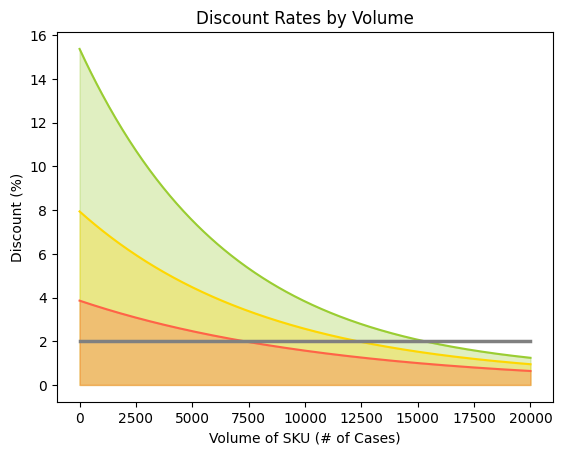

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Define the functions for 'intro', 'increment', and 'anchor'
def intro(x):
    return 1.00015**(18000-x) + 0.5

def increment(x):
    return 1.00012**(17000-x) + 0.25

def anchor(x):
    return 1.00009**(15000-x)

def overall(x):
    return 2 + (x-x)

# Create a range of values for x (Volume of SKU)
x_values = np.linspace(0, 20000, 400)

# Plot the functions
plt.plot(x_values, intro(x_values), label='intro', color='yellowgreen')
plt.plot(x_values, increment(x_values), label='increment', color='gold')
plt.plot(x_values, anchor(x_values), label='anchor', color='tomato')
plt.plot(x_values, overall(x_values), label='maximum overall', color='gray', linewidth=2.5)

# Add filled areas under the lines
plt.fill_between(x_values, intro(x_values), color='yellowgreen', alpha=0.3)
plt.fill_between(x_values, increment(x_values), color='gold', alpha=0.3)
plt.fill_between(x_values, anchor(x_values), color='tomato', alpha=0.3)

# Add a title and labels
plt.title('Discount Rates by Volume')
plt.xlabel('Volume of SKU (# of Cases)')
plt.ylabel('Discount (%)')

# Add a legend

# Save the plot as a PNG file
plt.savefig('discount_plot_filled.png', dpi=300)

# Show the plot
plt.show()



In [9]:
plt.savefig('discount_plots.jpg')

<Figure size 640x480 with 0 Axes>